# SVM with sigmoid kernel

The goal of this notebook is to find the best parameters for polynomial kernel. We also want to check if the parameters depend on stock.

We will use [sklearn.svm](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) library to perform calculations. We want to pick the best parameters for **SVC**:

* C (default 1.0)
* gamma (default 1/number_of_features, so 1 in our case)
* coef0 (default 0.0)

Sigmoid kernel function: $(\tanh(\gamma \langle x,x'\rangle + coef0))$

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import svm
import warnings

from lob_data_utils import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks (from dates 2013-09-01 - 2013-11-16) for which logistic regression yielded the best results.

We selected 3 subsets for each stock:
* training set (60% of data)
* test set (20% of data)
* cross-validation set (20% of data)

In [2]:
stocks = ['7858']

dfs = {}
dfs_cv = {}
dfs_test = {}

for s in stocks:
    df, df_cv, df_test = lob.load_prepared_data(s, cv=True, length=None)
    dfs[s] = df
    dfs_test[s] = df_cv
    dfs_cv[s] = df_test

Len of data for  7858 is 13791
Training set length for 7858: 8275
Testing set length for 7858: 2758
Cross-validation set length for 7858: 2758


In [3]:
dfs[stocks[0]].head()

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2758,2013-09-18 10:43:00,"[(2800.0, 500.0), (4100.0, 300.0), (4120.0, 50...","[(4490.0, 1025.0), (4491.0, 201.0), (4492.0, 5...",4486.0,4490.0,4488.0,1025.0,640.0,0.0,-0.231231
2759,2013-09-18 10:44:00,"[(2800.0, 500.0), (4100.0, 300.0), (4120.0, 50...","[(4489.0, 807.0), (4490.0, 272.0), (4491.0, 50...",4486.0,4489.0,4487.5,807.0,440.0,0.0,-0.294306
2760,2013-09-18 10:45:00,"[(2800.0, 500.0), (4100.0, 300.0), (4120.0, 50...","[(4488.0, 528.0), (4489.0, 726.0), (4490.0, 52...",4485.0,4488.0,4486.5,528.0,600.0,0.0,0.063830
2761,2013-09-18 10:46:00,"[(2800.0, 500.0), (4100.0, 300.0), (4120.0, 50...","[(4488.0, 157.0), (4489.0, 621.0), (4490.0, 58...",4484.0,4488.0,4486.0,157.0,667.0,1.0,0.618932
2762,2013-09-18 10:47:00,"[(2800.0, 500.0), (4100.0, 300.0), (4120.0, 50...","[(4489.0, 630.0), (4490.0, 397.0), (4491.0, 96...",4486.0,4489.0,4487.5,630.0,73.0,1.0,-0.792319


In [4]:
def svm_classification(d, kernel, gamma='auto', C=1.0, degree=3, coef0=0.0):
    clf = svm.SVC(kernel=kernel, gamma=gamma, C=C, degree=degree, coef0=coef0)
    X = d['queue_imbalance'].values.reshape(-1, 1)
    y = d['mid_price_indicator'].values.reshape(-1, 1)
    clf.fit(X, y)
    return clf

# Methodology

We will use at first naive approach to grasp how each of the parameter influences the ROC area score and what values make sense, when the other parameters are set to defaults for parameters C and gamma.

Next we will choose parameter coef0 for SVM with gamma and C set to the best values we got.

### C parameter

The C parameter has influence over margin picked by SVM:
* for large values of **C** SVM will choose a smaller-margin hyperplane, which means that more data points will be classified correctly
* for small values of **C** SVM will choose a bigger-margin hyperplane, so there may be more misclassifications

At first we tried parameters: [0.0001, 0.001, 0.01, 0.1, 1, 10, 1000], but after first calculations it seems that it wasn't enough, so a few more values were introduced or removed.

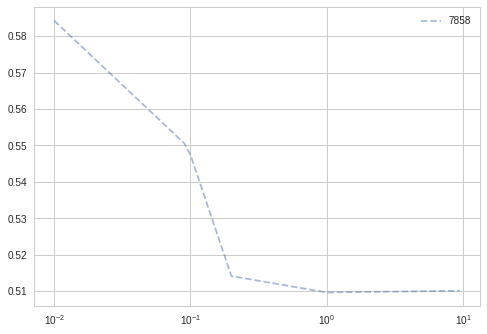

In [5]:
cs = [0.01, 0.09, 0.1, 0.2, 1, 8, 9, 9.5]
df_css = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_cs = pd.DataFrame(index=cs)
    df_cs['roc'] = np.zeros(len(df_cs))
    for c in cs:
        reg_svm = svm_classification(dfs[s], 'sigmoid', C=c, coef0=0)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_cs.loc[c] = logit_roc_auc
    plt.plot(df_cs, linestyle='--', label=s, marker='x', alpha=0.5)
    df_css[s] = df_cs
    
plt.legend()

##### Best values of C parameter

Choice of parameter C should be small - less than 0.1

In [6]:
for s in stocks:
    idx = df_css[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 7858 the best is 0.01


##### Influence of C parameter

The score difference between SVM with the worst choice of parameter **C** and the best choice one is shown on the output below.

In [7]:
for s in stocks:
    err_max = df_css[s]['roc'].max()
    err_min = df_css[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 7858 the diff between best and worst 0.07458031298335477


### Gamma

Gamma is a parameter which has influence over decision region - the bigger it is, the bigger influence every single row of data has. When gamma is low the decision region is very broad. When gamma is high it can even create islands of decision-boundaries around data points.

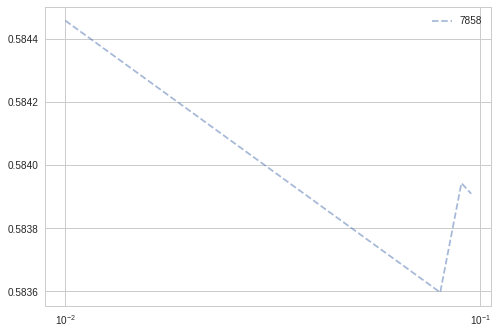

In [8]:
gammas = [0.01, 0.08, 0.09, 0.095]

df_gammas = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_gamma = pd.DataFrame(index=gammas)
    df_gamma['roc'] = np.zeros(len(df_gamma))
    for g in gammas:
        reg_svm = svm_classification(dfs[s], 'sigmoid', gamma=g, coef0=0)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))

        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_gamma.loc[g] = logit_roc_auc
    plt.plot(df_gamma, linestyle='--', label=s, marker='x', alpha=0.5)
    df_gammas[s] = df_gamma
    
plt.legend()

##### Best values of gamma

There is no rule, how to set this parameter.

In [9]:
for s in stocks:
    idx = df_gammas[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 7858 the best is 0.01


##### Influence of gamma

The score difference between SVM with the worst choice of **gamma** and the best choice one is shown on the output below. For scoring method we used *roc_area*. For stocks **10795**, **11618** and **4481** the difference is more than 0.1, so it's definitelly worth to experiment more.

In [10]:
for s in stocks:
    err_max = df_gammas[s]['roc'].max()
    err_min = df_gammas[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 7858 the diff between best and worst 0.0008616396449095953


In [11]:
df_params = {}

for s in stocks:
    print(s)
    params = []
    for c in cs:
        for g in gammas:
            reg_svm = svm_classification(dfs[s], 'sigmoid', C=c, gamma=g)
            prediction = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
            score = roc_auc_score(dfs_cv[s]['mid_price_indicator'], prediction)
            params.append({'score': score, 'gamma': g, 'c': c})
    df_params[s] = pd.DataFrame(params)

7858


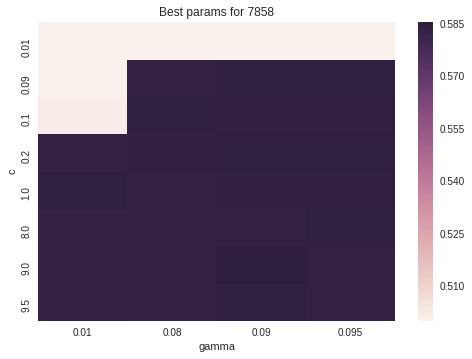

In [12]:
for s in stocks:
    df_g = df_params[s].pivot(index='c', columns='gamma', values='score')
    sns.heatmap(df_g)
    plt.title('Best params for ' + s)
    plt.figure()

In [13]:
for s in stocks:
    print(s, df_params[s].iloc[df_params[s]['score'].idxmax()])

7858 c        9.000000
gamma    0.090000
score    0.585526
Name: 26, dtype: float64


In [14]:
df_params[stocks[0]].sort_values(by='score', ascending=False).head(5)

,c,gamma,score
26,9.00,0.090,0.585526
9,0.10,0.080,0.584805
6,0.09,0.090,0.584805
15,0.20,0.095,0.584805
14,0.20,0.090,0.584805


### Coef0

For sigmoid kernel we use function:
$(\tanh(\gamma \langle x,x'\rangle + r))$, where r is specified by coef0.

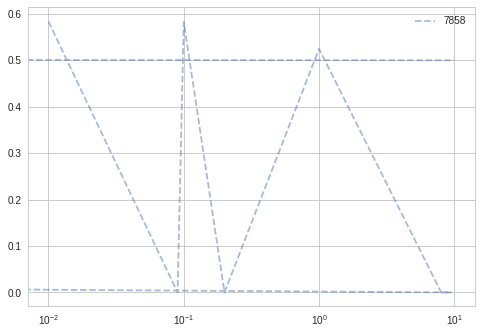

In [15]:
coeffs = [0, 0.01, 0.1, 1, 10]
# 10, 1
df_coefs = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_coef = pd.DataFrame(index=cs)
    df_coef['roc'] = np.zeros(len(df_coef))
    for c in coeffs:
        best_idx = df_params[s]['score'].idxmax()
        reg_svm = svm_classification(dfs[s], 'sigmoid', C=df_params[s].iloc[best_idx]['c'], 
                                     gamma=df_params[s].iloc[best_idx]['gamma'], coef0=c)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_coef.loc[c] = logit_roc_auc
    plt.plot(df_coef, linestyle='--', label=s, marker='x', alpha=0.5)
    df_coefs[s] = df_coef

plt.legend()

##### Best values of coef0

The value of coef0 should be rather small - less than 0.5.

In [16]:
for s in stocks:
    idx = df_coefs[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 7858 the best is 0.0


##### Influence of coef0

For all stocks choice of coef0 is significant, it can make even 0.5 difference.

In [17]:
for s in stocks:
    err_max = df_coefs[s]['roc'].max()
    err_min = df_coefs[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 7858 the diff between best and worst 0.5855257714573304


#### Best params so far

In [18]:
print(s, '\t', 'C', '\t', 'gamma', '\t', 'coef0')
    
for s in stocks:
    print(s, '\t', df_css[s]['roc'].idxmax(), '\t', df_gammas[s]['roc'].idxmax(), 
          '\t', df_coefs[s]['roc'].idxmax())

7858 	 C 	 gamma 	 coef0
7858 	 0.01 	 0.01 	 0.0


In [19]:
df_params_coef = {}
for s in stocks:
    print(s)
    params = []
    for idx, row in df_params[s].iterrows():
        for coef in coeffs:
            reg_svm = svm_classification(dfs[s], 'sigmoid', C=row['c'], 
                                         gamma=row['gamma'], coef0=coef)
            prediction = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
            score = roc_auc_score(dfs_cv[s]['mid_price_indicator'], prediction)
            params.append({'score': score, 'gamma': row['gamma'], 'c': row['c'], 'coef0': coef})
    df_params_coef[s] = pd.DataFrame(params)
    print(df_params_coef[s]['score'].idxmax())

    

7858
130


In [20]:
df_params_coef[stocks[0]].sort_values(by='score', 
                                      ascending=False)[df_params_coef[
    stocks[0]]['score'] > 0.57]

,c,coef0,gamma,score
130,9.00,0.00,0.090,0.585526
107,8.00,0.10,0.080,0.585369
31,0.09,0.01,0.090,0.584805
30,0.09,0.00,0.090,0.584805
66,0.20,0.01,0.080,0.584805
70,0.20,0.00,0.090,0.584805
46,0.10,0.01,0.080,0.584805
45,0.10,0.00,0.080,0.584805
75,0.20,0.00,0.095,0.584805
35,0.09,0.00,0.095,0.584805


# Results

We compare reults of SVMs with the best choices of parameter against the logistic regression and SVM with defaults.

We will use naive approach - for each stock we will just pick the best values we found in the previous section.

#### Naive approach

We pick the best **C** parameter and the best **gamma** separately from the results of [section above](#Methodology), which were obtained using cross-validation set. The **coef0** parameter "depend" of the choice of the rest of parameters.

For 3 stocks the results are quite good, the rest is very bad.

In [21]:
df_results = pd.DataFrame(index=stocks)
df_results['logistic'] = np.zeros(len(stocks))
df_results['sigmoid-tunned'] = np.zeros(len(stocks))
df_results['c-tunned'] = np.zeros(len(stocks))
df_results['coef-tunned'] = np.zeros(len(stocks))
df_results['gamma-tunned'] = np.zeros(len(stocks))

9.0 0.09 0.0


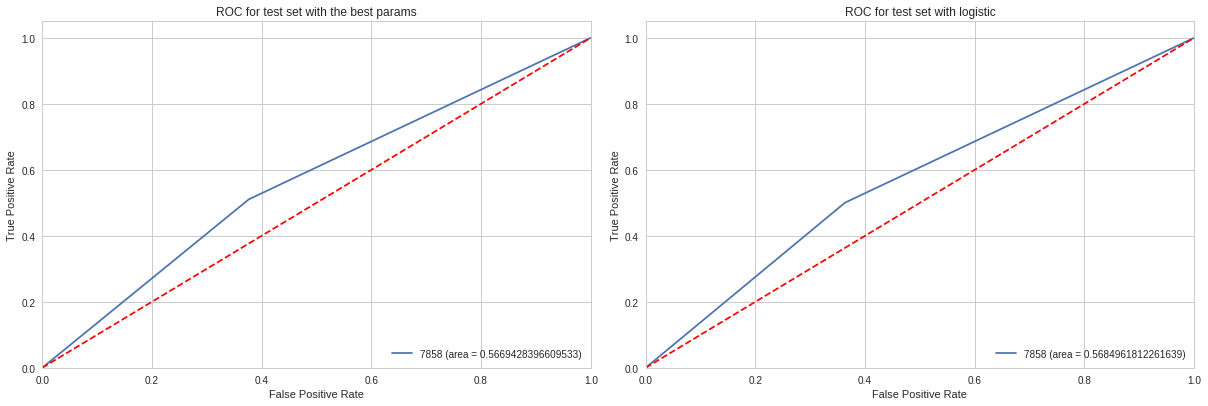

In [22]:
plt.subplot(121)

for s in stocks:
    best_idx = df_params_coef[s]['score'].idxmax()
    c = df_params_coef[s].iloc[best_idx]['c']
    gamma = df_params_coef[s].iloc[best_idx]['gamma']
    coef0 = df_params_coef[s].iloc[best_idx]['coef0']
    print(c, gamma, coef0)
    df_results['c-tunned'][s] = c
    df_results['coef-tunned'][s] = coef0
    df_results['gamma-tunned'][s] = gamma
    
    reg_svm = svm_classification(
        dfs[s], 'sigmoid', C=c, gamma=gamma, coef0=coef0)
    roc_score = lob.plot_roc(dfs_test[s], reg_svm, stock=s, title='ROC for test set with the best params')
    df_results['sigmoid-tunned'][s] = roc_score

plt.subplot(122)
for s in stocks:
    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    roc_score = lob.plot_roc(dfs_test[s], reg_log, stock=s, title='ROC for test set with logistic')
    df_results['logistic'][s] = roc_score

plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [23]:
df_results

,logistic,sigmoid-tunned,c-tunned,coef-tunned,gamma-tunned
7858,0.568496,0.566943,9.0,0.0,0.09


In [24]:
for s in stocks:
    ddd = df_params_coef[s]
    print(s)
    print(ddd.iloc[ddd['score'].idxmax()])
    print()

7858
c        9.000000
coef0    0.000000
gamma    0.090000
score    0.585526
Name: 130, dtype: float64



# Conclusions


We didn't use valid grid approach for choosing the best parameters, so there is possibility that these parameters could be improved. For one stock **2051** we have significant improvement (even when we consider other results). For stock **11618** we have small improvement.

### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a>